Remapping /home/usuario/Escritorio/BELEN/geonet/GOES_16_Samples/OR_ABI-L2-CMIPF-M3C02_G16_s20183532130334_e20183532141101_c20183532141174-114300_0.nc
- finished! Time: 19.258944272994995 seconds


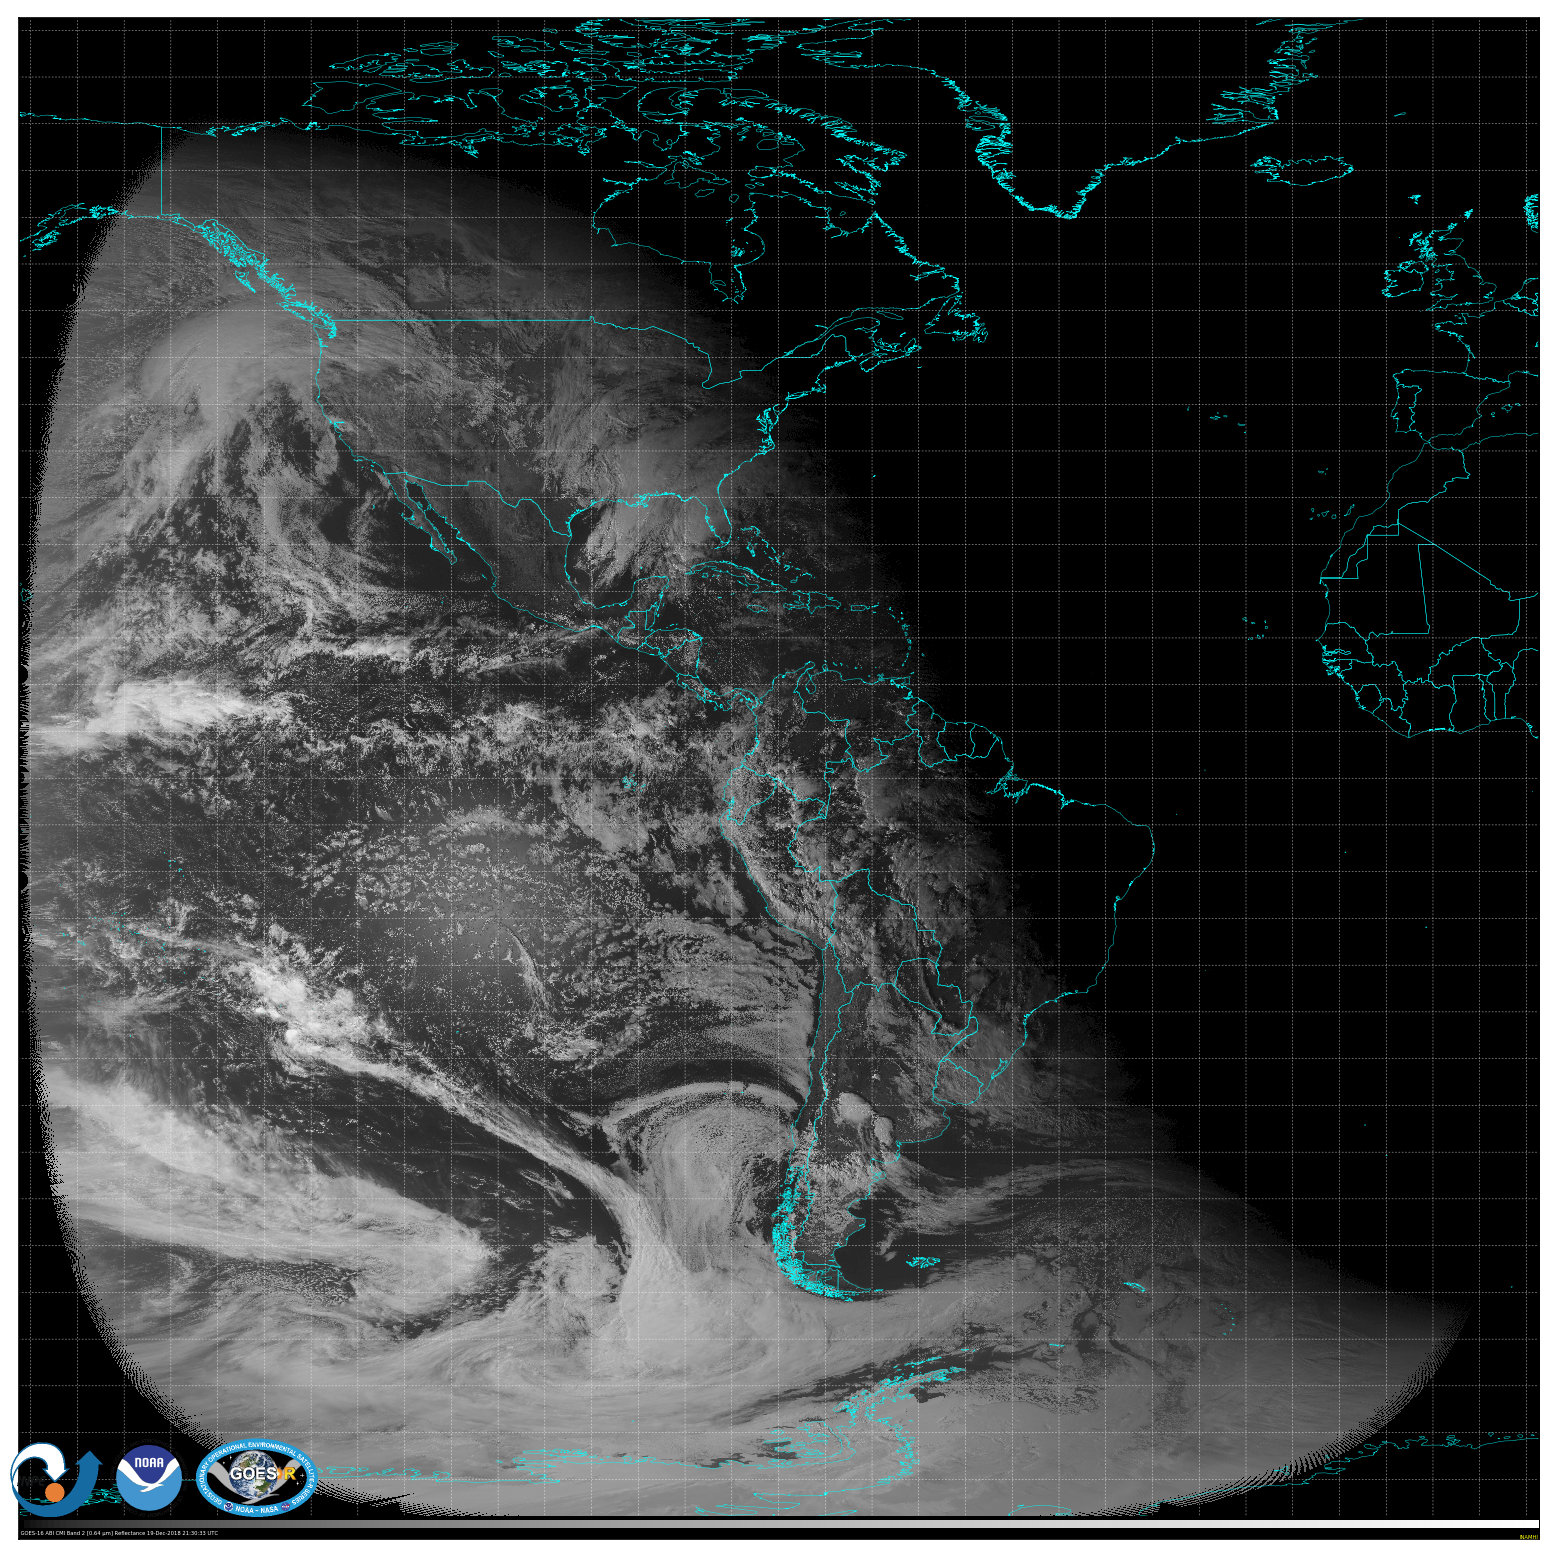

In [2]:
#======================================================================================================
# GNC-A Blog Python Tutorial: Part VIII
#======================================================================================================
 
# Required libraries ==================================================================================
import matplotlib.pyplot as plt # Import the Matplotlib package
from mpl_toolkits.basemap import Basemap # Import the Basemap toolkit
import numpy as np # Import the Numpy package 
from remap import remap # Import the Remap function
from cpt_convert import loadCPT # Import the CPT convert function
from matplotlib.colors import LinearSegmentedColormap # Linear interpolation for color maps
import datetime # Library to convert julian day to dd-mm-yyyy
from matplotlib.patches import Rectangle # Library to draw rectangles on the plot 
from netCDF4 import Dataset # Import the NetCDF Python interface
#======================================================================================================


# Load the Data =======================================================================================
# Path to the GOES-16 image file
path = '/home/usuario/Escritorio/BELEN/geonet/GOES_16_Samples/OR_ABI-L2-CMIPF-M3C02_G16_s20183532130334_e20183532141101_c20183532141174-114300_0.nc'
#======================================================================================================


# Getting information from the file name ==============================================================
# Search for the Scan start in the file name
Start = (path[path.find("_s")+2:path.find("_e")])
# Search for the GOES-16 channel in the file name
Band = int((path[path.find("M3C" or "M4C")+3:path.find("_G16")]))
# Create a GOES-16 Bands string array
Wavelenghts = ['[]','[0.47 μm]','[0.64 μm]','[0.865 μm]','[1.378 μm]','[1.61 μm]','[2.25 μm]','[3.90 μm]','[6.19 μm]','[6.95 μm]','[7.34 μm]','[8.50 μm]','[9.61 μm]','[10.35 μm]','[11.20 μm]','[12.30 μm]','[13.30 μm]']
# Converting from julian day to dd-mm-yyyy
year = int(Start[0:4])
dayjulian = int(Start[4:7]) - 1 # Subtract 1 because the year starts at "0"
dayconventional = datetime.datetime(year,1,1) + datetime.timedelta(dayjulian) # Convert from julian to conventional
date = dayconventional.strftime('%d-%b-%Y') # Format the date according to the strftime directives
time = Start [7:9] + ":" + Start [9:11] + ":" + Start [11:13] + " UTC" # Time of the Start of the Scan
# Get the unit based on the channel. If channels 1 trough 6 is Albedo. If channels 7 to 16 is BT.
if Band <= 6:
    Unit = "Reflectance"
else:
    Unit = "Brightness Temperature [°C]"
#Choose a title for the plot
Title = " GOES-16 ABI CMI Band " + str(Band) + " " + Wavelenghts[int(Band)] + " " + Unit + " " + date + " " + time
# Insert the institution name
Institution = "INAMHI"
#=============================================================================================================


# Open the file using the NetCDF4 library======================================================================
nc = Dataset(path)
# Get the latitude and longitude image bounds
geo_extent = nc.variables['geospatial_lat_lon_extent']
min_lon = float(geo_extent.geospatial_westbound_longitude)
max_lon = float(geo_extent.geospatial_eastbound_longitude)
min_lat = float(geo_extent.geospatial_southbound_latitude)
max_lat = float(geo_extent.geospatial_northbound_latitude)
# Choose the visualization extent (min lon, min lat, max lon, max lat)
#extent = [-85.0, -5.0, -60.0, 12.0]
extent = [min_lon, min_lat, max_lon, max_lat]
# Choose the image resolution (the higher the number the faster the processing is)
resolution = 2.0
# Calculate the image extent required for the reprojection
H = nc.variables['goes_imager_projection'].perspective_point_height
x1 = nc.variables['x_image_bounds'][0] * H
x2 = nc.variables['x_image_bounds'][1] * H
y1 = nc.variables['y_image_bounds'][1] * H
y2 = nc.variables['y_image_bounds'][0] * H
# Call the reprojection funcion
grid = remap(path, extent, resolution, x1, y1, x2, y2)
# Read the data returned by the function
if Band <= 6:
    data = grid.ReadAsArray()
else:
    data = grid.ReadAsArray() - 273.15
#=====================================================================================================


# Define the size of the saved picture================================================================
DPI = 150
ax = plt.figure(figsize=(2000/float(DPI), 2000/float(DPI)), frameon=True, dpi=DPI)
#=====================================================================================================    


# Plot the Data =======================================================================================
# Create the basemap reference for the Rectangular Projection
bmap = Basemap(llcrnrlon=extent[0], llcrnrlat=extent[1], urcrnrlon=extent[2], urcrnrlat=extent[3], epsg=4326)
# Draw the countries 
bmap.readshapefile('/home/usuario/Escritorio/BELEN/geonet/Countries_Shape/ne_10m_admin_0_countries','ne_10m_admin_0_countries',linewidth=0.20,color='cyan')    
# Draw parallels and meridians
bmap.drawparallels(np.arange(-90.0, 90.0, 5.0), linewidth=0.2, dashes=[4, 4], color='white', labels=[False,False,False,False], fmt='%g', labelstyle="+/-", xoffset=-0.80, yoffset=-1.00, size=7)
bmap.drawmeridians(np.arange(0.0, 360.0, 5.0), linewidth=0.2, dashes=[4, 4], color='white', labels=[False,False,False,False], fmt='%g', labelstyle="+/-", xoffset=-0.80, yoffset=-1.00, size=7)

if Band <= 6:
    cpt = loadCPT('/home/usuario/Escritorio/BELEN/geonet/Colortables/Square_Root_Visible_Enhancement.cpt')
    cpt_convert = LinearSegmentedColormap('cpt', cpt)
    bmap.imshow(data, origin='upper', cmap=cpt_convert, vmin=0, vmax=1)
    #cb = bmap.colorbar(location='bottom', size = '1%', pad = '-4%', ticks=[0.2, 0.4, 0.6, 0.8])
    #cb.ax.set_xticklabels(['20', '40', '60', '80'])
elif Band == 7:
    cpt = loadCPT('/home/usuario/Escritorio/BELEN/geonet/Colortables/SVGAIR2_TEMP.cpt')
    cpt_convert = LinearSegmentedColormap('cpt', cpt)
    bmap.imshow(data, origin='upper', cmap=cpt_convert, vmin=-112.15, vmax=56.85)
    #cb = bmap.colorbar(location='bottom', size = '1%', pad = '-4%')
elif Band > 7 and Band < 11:
    cpt = loadCPT('/home/usuario/Escritorio/BELEN/geonet/Colortables/SVGAWVX_TEMP.cpt')
    cpt_convert = LinearSegmentedColormap('cpt', cpt)
    bmap.imshow(data, origin='upper', cmap=cpt_convert, vmin=-112.15, vmax=56.85)
    #cb = bmap.colorbar(location='bottom', size = '1%', pad = '-4%')
elif Band > 10:
    cpt = loadCPT('/home/usuario/Escritorio/BELEN/geonet/Colortables/IR4AVHRR6.cpt')
    cpt_convert = LinearSegmentedColormap('cpt', cpt)
    bmap.imshow(data, origin='upper', cmap=cpt_convert, vmin=-103, vmax=84)
    #cb = bmap.colorbar(location='bottom', size = '1%', pad = '-4%')
    
if Band <= 6:
    # Insert the colorbar at the bottom
    # Plot the GOES-16 channel with the converted CPT colors (you may alter the min and max to match your preference)
    cb = bmap.colorbar(location='bottom', size = '0.5%', pad = '-1.2%', ticks=[20, 40, 60, 80])    
    cb.ax.set_xticklabels(['20', '40', '60', '80'])
else:
    # Insert the colorbar at the bottom
    cb = bmap.colorbar(location='bottom', size = '2.0%', pad = '-5%')
    
cb.outline.set_visible(False) # Remove the colorbar outline
cb.ax.tick_params(width = 0) # Remove the colorbar ticks
cb.ax.xaxis.set_tick_params(pad=-6) # Put the colobar labels inside the colorbar
cb.ax.tick_params(axis='x', colors='yellow', labelsize=2.5) # Change the color and size of the colorbar labels
# Add a black rectangle in the bottom to insert the image description
lon_difference = (extent[2] - extent[0]) # Max Lon - Min Lon
currentAxis = plt.gca()
currentAxis.add_patch(Rectangle((extent[0], extent[1]), lon_difference, lon_difference * 0.015, alpha=1, zorder=3, facecolor='black'))
# Add the image description inside the black rectangle
lat_difference = (extent[3] - extent[1]) # Max lat - Min lat
plt.text(extent[0], extent[1] + lat_difference * 0.003,Title,horizontalalignment='left', color = 'white', size=2.5)
plt.text(extent[2], extent[1],Institution, horizontalalignment='right', color = 'yellow', size=2.5)
# Add logos / images to the plot
logo_INPE = plt.imread('/home/usuario/Escritorio/BELEN/geonet/Logos/INPE_Logo.png')
logo_NOAA = plt.imread('/home/usuario/Escritorio/BELEN/geonet/Logos/NOAA_Logo.png')
logo_GOES = plt.imread('/home/usuario/Escritorio/BELEN/geonet/Logos/GOES_Logo.png')
ax.figimage(logo_INPE, 10, 40, zorder=3, alpha = 1, origin = 'upper')
ax.figimage(logo_NOAA, 110, 40, zorder=3, alpha = 1, origin = 'upper')
ax.figimage(logo_GOES, 195, 40, zorder=3, alpha = 1, origin = 'upper')
 
date_save = dayconventional.strftime('%d%m%Y')
time_save = Start [7:9] + Start [9:11] + Start [11:13]
#====================================================================================================================


# Save the result=======================================================================================
plt.savefig('/home/usuario/Escritorio/BELEN/geonet/Output/G16_C' + str(Band) + '_' + date_save + '_' + time_save + '.png', dpi=DPI, pad_inches=0)
#================================================================================================================
    
